# CA683 Assignment - Group 25
## As part of this assignment we are trying to predict Arteial Blood Pressure (ABP) Signal from photoplethysmography (PPG) Signal. The prediction is implemented through different models. Root Mean Square Error (RMSE), Mean Absolute Error (MAE) and Mean Absolute Percentage Error (MAPE) are calculated for each model and used as evaluation parameters. The models are compared  based on these parameters.


## Mounting Google Drive to load the required files

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Importing Libraries

In [2]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import warnings
import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras import optimizers
from scipy import signal
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')

## Providing Datapath of the mat files obtained from UCI. It consists of 8 mat files (3 X 63000)

In [3]:
datapath = '/content/drive/MyDrive/Kaggle/ABP_archive/'

## Defining Functions to load full and partial list of mat files

In [4]:
def load_data_partial(filename):
  mat_contents = sio.loadmat(filename) 

  return mat_contents

In [5]:
def load_data(fileDir, exercise):
    word = exercise.lower()
    file_path_list = []
    valid_file_extensions = [".mat"]
    valid_file_extensions = [item.lower() for item in valid_file_extensions]


    for file in os.listdir(fileDir):
        extension = os.path.splitext(file)[1]
        if extension.lower() not in valid_file_extensions:
            continue
        file_path_list.append(os.path.join(fileDir, file))

    Data = []
    for path in file_path_list:
        base=os.path.basename(path)
        base = os.path.splitext(base)[0]
        if word in base:
            print(fileDir+'/%s'%(base))
            mat_contents = sio.loadmat(fileDir+'/%s'%(base))
            val = mat_contents['p']
            total_array = val[0,:] #assigning an array
            Data.append(total_array)

    return Data

### Loading the MAT files

In [6]:
word = 'part'
total_data = load_data(datapath, word)
x =load_data_partial(datapath+str('part_1.mat'))

/content/drive/MyDrive/Kaggle/ABP_archive//part_7
/content/drive/MyDrive/Kaggle/ABP_archive//part_3
/content/drive/MyDrive/Kaggle/ABP_archive//part_4
/content/drive/MyDrive/Kaggle/ABP_archive//part_5
/content/drive/MyDrive/Kaggle/ABP_archive//part_8
/content/drive/MyDrive/Kaggle/ABP_archive//part_2
/content/drive/MyDrive/Kaggle/ABP_archive//part_1
/content/drive/MyDrive/Kaggle/ABP_archive//part_6


In [7]:
x.keys()


dict_keys(['__header__', '__version__', '__globals__', 'p'])

### Plotting the ABP signal for 1000 samples (normalized values and scaled back values)

(3, 61000)


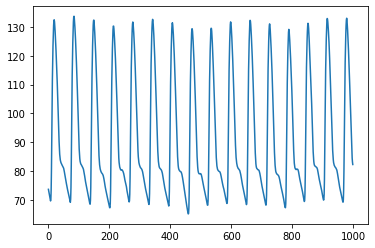

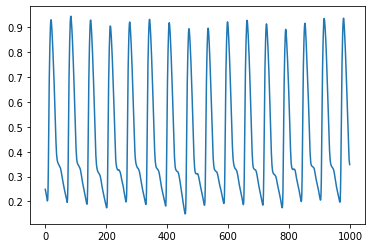

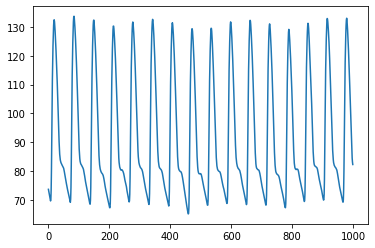

In [8]:
abp_list = x['p'][0,1]
print(abp_list.shape)
abp = x['p'][0,1][1,:1000]


x_max = max(abp_list[1,:])
x_min = min(abp_list[1,:])


plt.figure()
plt.plot(abp)

nrm_abp = (abp-x_min)/(x_max-x_min)  # Normalizing Data between 0 and 1
plt.figure()
plt.plot(nrm_abp)


ret_abp = nrm_abp*(x_max - x_min) +x_min   #Reversed from normalized value
plt.figure()
plt.plot(ret_abp)

## Setting the configuration parameters for the models

In [9]:
config = {
    'seed': 77,
    'sample_size': 1000,
    'train_size': 3000000, # train on 3 million data points
    'train_params':{
        'batch_size':32,
        'epochs': 50,
        'learn_rate': 0.0001,#1e-3,
    }
}

In [10]:
# Initializing TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# Instantiate distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
    
auto = tf.data.experimental.AUTOTUNE
replicas = tpu_strategy.num_replicas_in_sync
Batch_size = config['train_params']['batch_size'] * replicas
print(f'Number of Replicas: {replicas}')

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.81.236.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.81.236.2:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Number of Replicas: 8


In [11]:
def SetSeed(seed=None):
    """Set seed for reproducibility."""
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
SetSeed(seed=config['seed'])

In [12]:
print(len(total_data))
print(len(total_data[1]))
print(total_data[1][1].shape)

8
1000
(3, 8000)


In [13]:
print(total_data[0][1])

[[ 0.31671554  0.34213099  0.37438905 ...  0.72825024  0.71945259
   0.70772239]
 [87.02743613 86.83186886 86.83186886 ... 73.92442889 73.53329435
  72.94659253]
 [ 0.58039216  0.58039216  0.59019608 ...  0.53921569  0.52941176
   0.51960784]]


## Feature Extraction: Extracting PPG ,ECG and ABP values from total_data

In [14]:
PPG = []
ABP = []
ECG = []
i=0
for j in range(len(total_data[i])):
  k = len(total_data[i][j][0,:])
  for n in range(k//1000):
      ppg = (total_data[i][j][0,(n*1000):(n*1000)+1000]) # Extracting PPG values
      abp = (total_data[i][j][1,(n*1000):(n*1000)+1000]) #Extracting ABP values
      ecg = (total_data[i][j][2,(n*1000):(n*1000)+1000]) #Extracting ECG values
      PPG.append(ppg)
      ABP.append(abp)
      ECG.append(ecg)

# Converting list of PPG,ECG and ABP as array
PPG = np.asarray(PPG)
ABP = np.asarray(ABP)
ECG = np.asarray(ECG)


In [15]:
PPG

array([[0.52199413, 0.50733138, 0.49462366, ..., 0.34213099, 0.33822092,
        0.33431085],
       [0.33040078, 0.3255132 , 0.32062561, ..., 0.43108504, 0.42424242,
        0.41837732],
       [0.4115347 , 0.40469208, 0.39882698, ..., 0.59042033, 0.57380254,
        0.55718475],
       ...,
       [1.53176931, 1.51319648, 1.49364614, ..., 1.57380254, 1.66568915,
        1.77908113],
       [1.7370479 , 1.70381232, 1.6744868 , ..., 1.34115347, 1.33919844,
        1.33822092],
       [2.88367546, 2.8973607 , 2.90322581, ..., 2.71652004, 2.64125122,
        2.5601173 ]])

In [16]:
PPG.shape

(15486, 1000)

In [17]:
len(PPG)

15486

### Plotting graphs for PPG,ECG and ABP signals

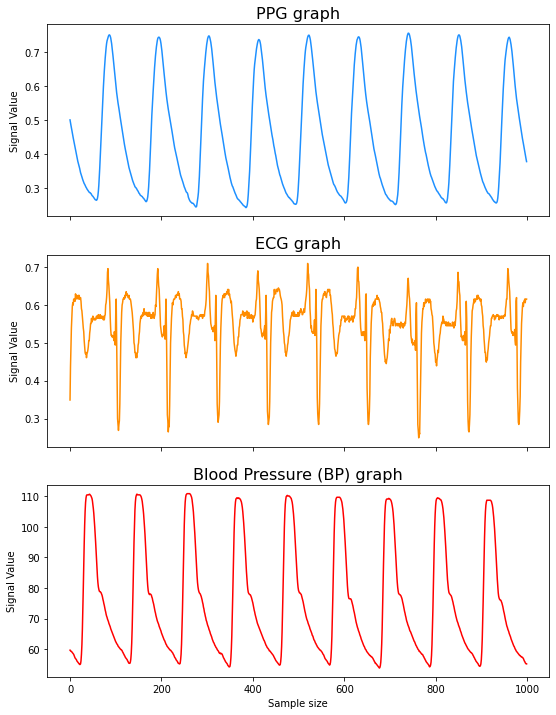

In [18]:
# ##plotting sample  ppg, ecg and bp signals
# ##using a sample size of 1000
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)
y = 1000
ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(PPG[y,:], c = 'dodgerblue')

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ECG[y,:], c='darkorange')

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(ABP[y,:], c = 'red')

## Splitting the data into 70% train and 30% test

**Input** : * PPG values*

**Output**:  *ABP values*

In [19]:
# creating train and val sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(PPG, ABP, test_size=0.30)

In [20]:
X_train1

array([[1.80449658, 1.76735093, 1.73313783, ..., 1.29423265, 1.41642229,
        1.55034213],
       [2.90615836, 2.86999022, 2.83870968, ..., 2.07526882, 2.0342131 ,
        1.9941349 ],
       [0.33626588, 0.3313783 , 0.32746823, ..., 0.35190616, 0.34604106,
        0.34115347],
       ...,
       [2.15640274, 2.09481916, 2.03519062, ..., 1.84359726, 1.78494624,
        1.73313783],
       [1.14076246, 1.12707722, 1.1143695 , ..., 1.07526882, 1.07135875,
        1.06744868],
       [2.24046921, 2.18670577, 2.13489736, ..., 2.81427175, 2.76246334,
        2.7028348 ]])

In [21]:
y_train1

array([[ 71.06817172,  70.72626299,  70.43319836, ...,  91.4361632 ,
         90.55696932,  89.48239903],
       [ 69.21078272,  68.9509581 ,  68.69113348, ...,  64.01429035,
         63.9493342 ,  63.75446574],
       [ 57.30121076,  58.86574893,  61.79925802, ...,  58.86574893,
         59.64801802,  61.60369075],
       ...,
       [ 68.08868136,  67.60024031,  67.11179927, ...,  59.58980721,
         58.66176923,  57.78257535],
       [ 86.39536724,  95.36313602, 104.74119488, ..., 128.2449549 ,
        125.19708577, 121.97337804],
       [ 61.7877919 ,  61.44588317,  61.10397444, ...,  68.82134292,
         67.99099315,  67.30717569]])

## Linear Model without Normalizing PPG,ECG and ABP values

In [22]:
#Linear Regression with Values of PPG
import numpy as np
from sklearn.linear_model import LinearRegression
linear_model_std = LinearRegression()
linear_model_std.fit(X_train1, y_train1)

LinearRegression()

In [23]:
# Prediction of BP values from PPG values using LR model
y_pred1 = linear_model_std.predict(X_test1)

In [24]:
#Caculation of RMSE
rmse= np.sqrt(np.mean((y_pred1-y_test1)**2))
print(f'LR standard model RMSE is: {rmse}')

LR standard model RMSE is: 21.979865099496564


In [25]:
#Checking MAE error for LR model (not normalized input and output)
LR_std__MAE= tf.keras.metrics.MeanAbsoluteError()
LR_std__MAE.update_state(y_test1, y_pred1)
print(f'LR_std_Model MAE: {LR_std__MAE.result().numpy()}')

LR_std_Model MAE: 14.538209915161133


In [26]:
# Checking if y_test1 and y_pred1 have any NaN values
print(len(y_test1))
print(len(y_pred1))
print(np.isnan(y_test1).any())
print(np.isnan(y_pred1).any())
print(np.argwhere(np.isnan(y_test1)))

4646
4646
False
False
[]


In [89]:
#Checking Mean Arterial Pressure for LR model
score = []
for i in range(len(y_test1)):
  score.append(abs(y_test1[i]-y_pred1[i]))

print("Average MAP error for LR standard model is: %f mmHG" %(np.mean(score)))
print("Average Standard Deviation for LR standard model is: %f mmHG" %(np.std(score)))

Average MAP error for LR standard model is: 14.538211 mmHG
Average Standard Deviation for LR standard model is: 16.484990 mmHG


### Plotting graph for True vs Predicted BP values using LR model 

(without Normalizing PPG and BP values)

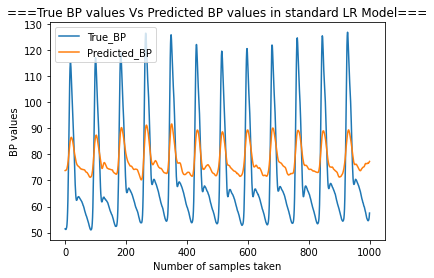

In [28]:
# Visualize predicted BP and the True BP in standard Linear Model
plt.title("===True BP values Vs Predicted BP values in standard LR Model===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test1[1000,:]) #only plotting 100 samples
plt.plot(y_pred1[1000,:])
plt.legend(['True_BP', 'Predicted_BP'])

## Defining Function to Normalize the PPG and ABP values

In [29]:
def normalise(x):
  normalised = (x-min(x))/(max(x)-min(x))
  return normalised

def scale_abp(x):
  normalised = x/200
  return normalised

def normalise_abp(abp, x_max, x_min):
  normalised = (abp-x_min)/(x_max-x_min)
  return normalised

def abp_maxmin_value(x):
  max_x = []
  min_x = []
  for i in range(len(x)):
    for j in range(len(x[i])):
      max_x.append(max(x[i][j][1,:]))
      min_x.append(min(x[i][j][1,:]))
  x_max = max(max_x)
  x_min = min(min_x)

  return x_max, x_min

### Checking Minimum and Maximum values in total_data

In [30]:
x_max, x_min = abp_maxmin_value(total_data)
print(x_max, x_min)
x_max = 200.0
x_min = 50.0

199.98749589709124 50.0


## Feature Extraction and Feature Scaling: Extracting PPG ,ECG and ABP values from total_data and normalizing them

In [31]:
# #Data Pre-processing
# # Extracting signal data Feature-extraction
PPG_N = []
ABP_N = []
ECG_N = []
i=0
for j in range(len(total_data[i])):
  k = len(total_data[i][j][0,:])
  for n in range(k//1000):
      ppg_n = normalise(total_data[i][j][0,(n*1000):(n*1000)+1000])
      abp_n = normalise_abp(total_data[i][j][1,(n*1000):(n*1000)+1000], x_max, x_min)
      ecg_n = normalise(total_data[i][j][2,(n*1000):(n*1000)+1000])
      PPG_N.append(ppg_n)
      ABP_N.append(abp_n)
      ECG_N.append(ecg_n)


PPG_N = np.asarray(PPG_N)
ABP_N = np.asarray(ABP_N)
ECG_N = np.asarray(ECG_N)


In [32]:
PPG_N

array([[0.55617978, 0.52808989, 0.50374532, ..., 0.21161049, 0.20411985,
        0.19662921],
       [0.16763006, 0.15799615, 0.14836224, ..., 0.36608863, 0.35260116,
        0.34104046],
       [0.35985533, 0.34719711, 0.3363472 , ..., 0.69077758, 0.66003617,
        0.62929476],
       ...,
       [0.29273897, 0.28400735, 0.27481618, ..., 0.3125    , 0.35569853,
        0.40900735],
       [0.3841629 , 0.36877828, 0.35520362, ..., 0.20090498, 0.2       ,
        0.19954751],
       [0.91083618, 0.91680887, 0.9193686 , ..., 0.83788396, 0.80503413,
        0.76962457]])

In [33]:
PPG_N.shape

(15486, 1000)

In [34]:
len(PPG_N)

15486

### Plotting graphs for Normalized PPG,ECG and ABP signals

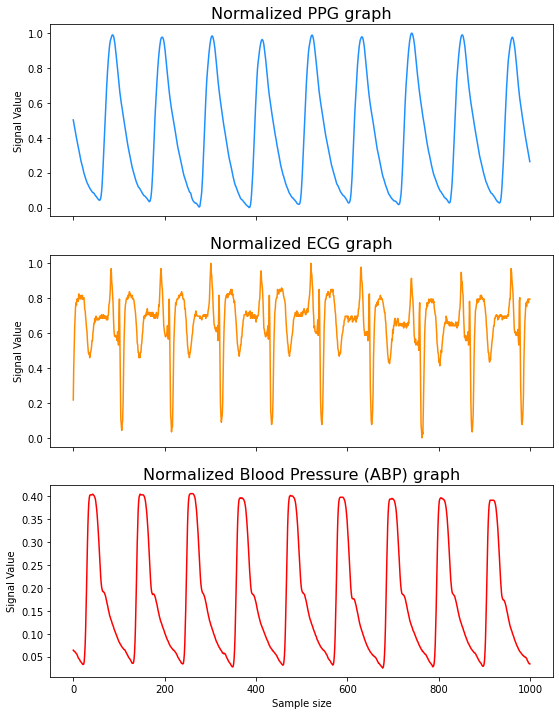

In [35]:
# ##plotting sample normalized ppg, ecg and bp signals
# ##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)
y = 1000
ax[0].set_title('Normalized PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(PPG_N[y,:], c = 'dodgerblue')

ax[1].set_title('Normalized ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ECG_N[y,:], c='darkorange')

ax[2].set_title('Normalized Blood Pressure (ABP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(ABP_N[y,:], c = 'red')

## Splitting the normalized data into 70% train and 30% test 
**Input** : *Normalized PPG values*

**Output**: *Normalized ABP values*

In [36]:
# creating train and val sets
X_train, X_test, y_train, y_test = train_test_split(PPG_N, ABP_N, test_size=0.30)

In [37]:
X_train

array([[0.13193117, 0.12619503, 0.12045889, ..., 0.10516252, 0.09942639,
        0.09560229],
       [0.19972388, 0.19466176, 0.18913944, ..., 0.42797975, 0.38840313,
        0.35112747],
       [0.75961538, 0.82600733, 0.8768315 , ..., 0.41712454, 0.38049451,
        0.34661172],
       ...,
       [1.        , 1.        , 0.99437148, ..., 0.77485929, 0.82363977,
        0.86491557],
       [0.43373494, 0.5060241 , 0.57487091, ..., 0.33907057, 0.33046472,
        0.32358003],
       [0.09082734, 0.08678058, 0.08183453, ..., 0.78417266, 0.80710432,
        0.82239209]])

In [38]:
X_train.shape

(10840, 1000)

In [39]:
y_train

array([[0.07475037, 0.1086487 , 0.14645837, ..., 0.24815336, 0.27031765,
        0.28596303],
       [0.34527409, 0.34201782, 0.3371334 , ..., 0.08705159, 0.08444657,
        0.0811903 ],
       [0.1824589 , 0.17985388, 0.17750937, ..., 0.16630783, 0.16422382,
        0.16213981],
       ...,
       [0.18687561, 0.18296427, 0.17905292, ..., 0.21816637, 0.21295125,
        0.20773612],
       [0.12168652, 0.11907896, 0.11647139, ..., 0.04085205, 0.04867474,
        0.06171256],
       [0.25670345, 0.2394452 , 0.22186132, ..., 0.1573871 , 0.16162026,
        0.16520216]])

## Linear Model With Normalized PPG and ABP values

In [40]:
#Linear Regression with Normalized Values of PPG
import numpy as np
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [41]:
## Prediction of BP values from PPG values using LR model
y_pred = linear_model.predict(X_test)

In [42]:
#Calculating RMSE
rmse= np.sqrt(np.mean((y_pred-y_test)**2))
print(f'LR model RMSE is: {rmse}')

LR model RMSE is: 0.11871120237401452


In [43]:
#Checking MAE error for Linear Regression Model
LR_MAE= tf.keras.metrics.MeanAbsoluteError()
LR_MAE.update_state(y_test, y_pred)
print(f'LR Model MAE: {LR_MAE.result().numpy()}')

LR Model MAE: 0.08203183114528656


In [44]:
# Checking if y_test and y_pred have any NaN values
print(len(y_test))
print(len(y_pred))
print(np.isnan(y_test).any())
print(np.isnan(y_pred).any())
print(np.argwhere(np.isnan(y_test)))

4646
4646
False
False
[]


In [45]:
#Scaling back y_test and y_pred to original values to calculate Mean Arterial Pressure (MAP) Error
y_test_sb = y_test*(x_max - x_min) +x_min 
y_pred_sb = y_pred*(x_max - x_min) +x_min 

In [46]:
y_test_sb

array([[ 68.05741073,  67.07957437,  66.29730528, ...,  60.03915257,
         59.64801802,  59.06131621],
       [ 62.58152711,  62.19039256,  61.79925802, ...,  66.68843982,
         66.29730528,  65.90617073],
       [ 55.29152604,  55.19383783,  55.04730551, ...,  90.3615929 ,
         87.23557023,  84.06070345],
       ...,
       [105.01962518, 102.08611609,  99.9348761 , ..., 118.70933423,
        115.77582515, 112.25561425],
       [ 73.33772708,  73.14215981,  72.75102526, ...,  63.3637962 ,
         63.16822892,  62.77709438],
       [103.25951973, 109.71323971, 115.77582515, ...,  93.48115612,
         93.09002157,  92.69888703]])

In [48]:
y_pred_sb

array([[ 75.95795142,  75.41679695,  75.30165952, ...,  73.31914936,
         72.17533175,  71.03106624],
       [ 77.42894409,  77.28363972,  77.18506733, ...,  69.1952736 ,
         67.79307942,  66.80446508],
       [ 93.16139065,  99.59004867, 105.36893317, ...,  87.00841389,
         85.91109803,  85.35765291],
       ...,
       [ 87.16021405,  83.65923064,  80.75175116, ..., 107.45838744,
        107.72086642, 107.96525596],
       [ 83.51778267,  83.64044091,  83.81539046, ...,  65.2783575 ,
         65.8229549 ,  66.31661331],
       [ 88.61933062,  96.47377093, 103.84505344, ...,  75.22690523,
         74.64157654,  74.28715387]])

In [49]:
#Checking MAP for LR model
score = []
for i in range(len(y_test_sb)):
  score.append(abs(y_test_sb[i]-y_pred_sb[i]))

print("Average MAP error for LR model is: %f mmHG" %(np.mean(score)))
print("Standard Deviation of LR Model is: %f mmHG" %(np.std(score)))

Average MAP error for LR model is: 12.304774 mmHG
Standard Deviation of LR Model is: 12.871301 mmHG


### Plotting graph for True vs Predicted BP values using LR model
(with Normalized PPG and BP values)

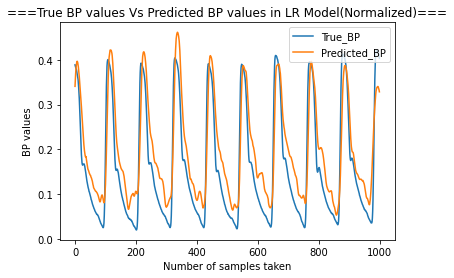

In [50]:
# Visualize predicted BP and the True BP in standard LR model
plt.title("===True BP values Vs Predicted BP values in LR Model(Normalized)===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[1000,:]) #only plotting 100 samples
plt.plot(y_pred[1000,:])
plt.legend(['True_BP', 'Predicted_BP'])

## Artificial Neural Network Model With Normalized PPG and ABP values

In [51]:
# Baseline Sequential Model
from keras import backend as K
K.clear_session() 

def Model(input_dim, num_class):
    model = Sequential()

    model.add(layers.Dense(2048, input_dim = input_dim, activation='sigmoid'))
    # model.add(layers.LSTM(512, input_dim = input_dim, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(512, 'relu')) 
    model.add(layers.Dropout(0.25))
    # model.add(layers.Dense(64, 'relu'))    
    # model.add(layers.Dropout(0.25))
    model.add(layers.Dense(num_class, 'linear'))
    
    
    return model

Input_dim = X_train.shape[1]
Classes = 1000

# Creating the model on TPU
with tpu_strategy.scope():
  model = Model(input_dim=Input_dim, num_class=Classes)
  model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  optimizer='adam',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()]
                 )
  model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 2048)              2050048   
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1000)              5

### Training the ANN Model

In [52]:
# Training the ANN model
ANN_model_train = model.fit(X_train[:config['train_size']], # using the first 3 million rows.
                    y_train[:config['train_size']],
                    validation_split=0.1,
                    epochs=config['train_params']['epochs'],
                    batch_size=Batch_size,
                    verbose = 1
                   )

Epoch 1/50
39/39 [==============================] - 11s 149ms/step - loss: 0.1551 - root_mean_squared_error: 0.2204 - val_loss: 0.1230 - val_root_mean_squared_error: 0.1782
Epoch 2/50
39/39 [==============================] - 1s 36ms/step - loss: 0.1222 - root_mean_squared_error: 0.1692 - val_loss: 0.1200 - val_root_mean_squared_error: 0.1719
Epoch 3/50
39/39 [==============================] - 1s 38ms/step - loss: 0.1203 - root_mean_squared_error: 0.1671 - val_loss: 0.1186 - val_root_mean_squared_error: 0.1694
Epoch 4/50
39/39 [==============================] - 1s 38ms/step - loss: 0.1176 - root_mean_squared_error: 0.1636 - val_loss: 0.1144 - val_root_mean_squared_error: 0.1637
Epoch 5/50
39/39 [==============================] - 1s 38ms/step - loss: 0.1139 - root_mean_squared_error: 0.1583 - val_loss: 0.1087 - val_root_mean_squared_error: 0.1506
Epoch 6/50
39/39 [==============================] - 1s 35ms/step - loss: 0.1109 - root_mean_squared_error: 0.1538 - val_loss: 0.1061 - val_root

### Prediction of BP values from normalized PPG values from test set - ANN

In [53]:
#Predicting on the test set using the ANN( artificial neural network) model
ANN_predictions = model.predict(X_test[:config['train_size']])
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test[:config['train_size']], ANN_predictions)
print(f' ANN Model RMSE: {rmse.result().numpy()}')

 ANN Model RMSE: 0.11087793856859207


In [54]:
len(ANN_predictions)

4646

In [55]:
type(ANN_predictions)

numpy.ndarray

In [56]:
ANN_predictions

array([[0.11442088, 0.11298689, 0.10863139, ..., 0.08258565, 0.08313722,
        0.08687229],
       [0.13760567, 0.13878073, 0.1321401 , ..., 0.14911042, 0.14594254,
        0.14668854],
       [0.29438993, 0.28999108, 0.28454095, ..., 0.24080381, 0.2314103 ,
        0.22697893],
       ...,
       [0.3363037 , 0.32488796, 0.31245804, ..., 0.48944065, 0.48281333,
        0.4861784 ],
       [0.1585832 , 0.15174213, 0.14670293, ..., 0.10784083, 0.10632904,
        0.11072402],
       [0.37592438, 0.39031962, 0.39988816, ..., 0.1438201 , 0.15206254,
        0.16161776]], dtype=float32)

In [57]:
#Checking MAE error for ANN Model
ANN_MAE= tf.keras.metrics.MeanAbsoluteError()
ANN_MAE.update_state(y_test, ANN_predictions)
print(f'ANN Model MAE: {ANN_MAE.result().numpy()}')

ANN Model MAE: 0.07631167024374008


In [58]:
# Checking if y_test and ANN_predictions have any NaN values
print(len(y_test))
print(len(ANN_predictions))
print(np.isnan(y_test).any())
print(np.isnan(ANN_predictions).any())
print(np.argwhere(np.isnan(y_test)))

4646
4646
False
False
[]


In [59]:
#Scaling back y_test and ANN_Prediction to original values to calculate Mean Arterial Pressure (MAP) Error for ANN model
y_tann_sb = y_test*(x_max - x_min) +x_min
ANN_pred_sb = ANN_predictions*(x_max - x_min) +x_min 


In [60]:
y_tann_sb

array([[ 68.05741073,  67.07957437,  66.29730528, ...,  60.03915257,
         59.64801802,  59.06131621],
       [ 62.58152711,  62.19039256,  61.79925802, ...,  66.68843982,
         66.29730528,  65.90617073],
       [ 55.29152604,  55.19383783,  55.04730551, ...,  90.3615929 ,
         87.23557023,  84.06070345],
       ...,
       [105.01962518, 102.08611609,  99.9348761 , ..., 118.70933423,
        115.77582515, 112.25561425],
       [ 73.33772708,  73.14215981,  72.75102526, ...,  63.3637962 ,
         63.16822892,  62.77709438],
       [103.25951973, 109.71323971, 115.77582515, ...,  93.48115612,
         93.09002157,  92.69888703]])

In [61]:
ANN_pred_sb

array([[ 67.16313 ,  66.94804 ,  66.29471 , ...,  62.387848,  62.47058 ,
         63.030846],
       [ 70.640854,  70.81711 ,  69.821014, ...,  72.36656 ,  71.89138 ,
         72.00328 ],
       [ 94.15849 ,  93.49866 ,  92.68114 , ...,  86.120575,  84.71155 ,
         84.046844],
       ...,
       [100.44556 ,  98.73319 ,  96.868706, ..., 123.4161  , 122.422   ,
        122.92676 ],
       [ 73.787476,  72.76132 ,  72.00544 , ...,  66.176125,  65.949356,
         66.608604],
       [106.38866 , 108.54794 , 109.98322 , ...,  71.57301 ,  72.80938 ,
         74.24266 ]], dtype=float32)

In [62]:
#Checking MAP error for ANN model
score = []
for i in range(len(y_tann_sb)):
  score.append(abs(y_tann_sb[i]-ANN_pred_sb[i]))

print("Average MAP error for ANN model is: %f mmHG" %(np.mean(score)))
print("Standard Deviation of ANN Model is: %f mmHG" %(np.std(score)))

Average MAP error for ANN model is: 11.446750 mmHG
Standard Deviation of ANN Model is: 12.065863 mmHG


### Plotting graph for Train Loss vs RMSE using ANN model
(with Normalized PPG and BP values)

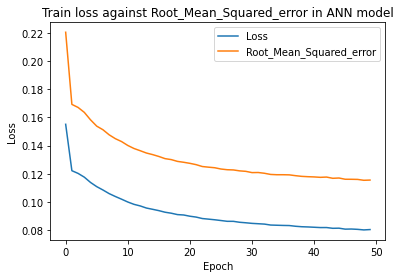

In [63]:
#Visualizing ANN model Train Loss vs RMSE
plt.title('Train loss against Root_Mean_Squared_error in ANN model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(ANN_model_train.history['loss'])
plt.plot(ANN_model_train.history['root_mean_squared_error'])
plt.legend(['Loss', 'Root_Mean_Squared_error'])

### Plotting graph for True vs Predicted BP values using ANN
(with Normalized PPG and BP values)

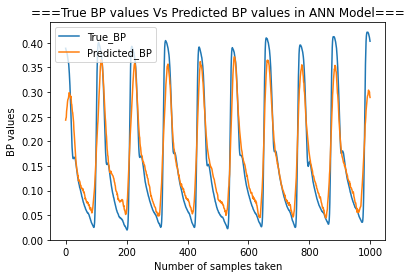

In [64]:
# Visualize predicted BP and the True BP in ANN model
plt.title("===True BP values Vs Predicted BP values in ANN Model===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[1000,:]) #only plotting 100 samples
plt.plot(ANN_predictions[1000,:])
plt.legend(['True_BP', 'Predicted_BP'])

## LSTM Model

### Reshaping the X_train and X_test values for LSTM model
The input to a LSTM model should be 3D(Sample Size, Time Step and Number of Features). Hence reshaping X_train and X_test to match the required input dimension.

In [65]:
X_train_reshape = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [66]:
X_train_reshape.shape

(10840, 1000, 1)

In [67]:
X_train_reshape

array([[[0.13193117],
        [0.12619503],
        [0.12045889],
        ...,
        [0.10516252],
        [0.09942639],
        [0.09560229]],

       [[0.19972388],
        [0.19466176],
        [0.18913944],
        ...,
        [0.42797975],
        [0.38840313],
        [0.35112747]],

       [[0.75961538],
        [0.82600733],
        [0.8768315 ],
        ...,
        [0.41712454],
        [0.38049451],
        [0.34661172]],

       ...,

       [[1.        ],
        [1.        ],
        [0.99437148],
        ...,
        [0.77485929],
        [0.82363977],
        [0.86491557]],

       [[0.43373494],
        [0.5060241 ],
        [0.57487091],
        ...,
        [0.33907057],
        [0.33046472],
        [0.32358003]],

       [[0.09082734],
        [0.08678058],
        [0.08183453],
        ...,
        [0.78417266],
        [0.80710432],
        [0.82239209]]])

In [68]:
X_test_reshape =np.reshape(X_test,(X_test.shape[0] ,X_test.shape[1],1))

In [69]:
X_test_reshape.shape

(4646, 1000, 1)

In [70]:
X_test_reshape

array([[[0.89799636],
        [0.88342441],
        [0.86338798],
        ...,
        [0.39162113],
        [0.38433515],
        [0.38069217]],

       [[0.97131931],
        [0.95984704],
        [0.94263862],
        ...,
        [0.71892925],
        [0.79541109],
        [0.86615679]],

       [[0.18600282],
        [0.17989667],
        [0.1728511 ],
        ...,
        [0.19116956],
        [0.19445749],
        [0.19727572]],

       ...,

       [[0.26510067],
        [0.23993289],
        [0.21979866],
        ...,
        [0.31543624],
        [0.29362416],
        [0.27348993]],

       [[0.64421416],
        [0.68911917],
        [0.72884283],
        ...,
        [0.58031088],
        [0.56131261],
        [0.54576857]],

       [[0.21666667],
        [0.23166667],
        [0.25166667],
        ...,
        [0.525     ],
        [0.49166667],
        [0.46      ]]])

In [71]:
from keras import backend as K
from keras import Model as md
from keras import regularizers
K.clear_session()
def LSTM_Model(input_dim,num_class):
  model = Sequential()
  model.add(layers.LSTM(64, return_sequences=True, input_shape = (X_train_reshape.shape[1],1)))
  #model.add(layers.Dense(25,activation='relu'))
  model.add(layers.Dropout(0.5))
  model.add(layers.LSTM(32,return_sequences=False))
  model.add(layers.Dense(num_class))
  return model
Input_dim= X_train_reshape
Classes = 1000

# # Creating the model on TPU
with tpu_strategy.scope():
  model = LSTM_Model(input_dim=Input_dim,num_class=Classes)
  model.compile(loss='mse',optimizer='adam',metrics=[tf.keras.metrics.RootMeanSquaredError()])
  from keras.callbacks import ModelCheckpoint, EarlyStopping
  es = EarlyStopping(monitor='val_loss',patience=10, min_delta=1e-3,mode='auto')
  model.summary()
  #tf.keras.optimizers.SGD(lr=config['train_params']['learn_rate'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 64)          16896     
                                                                 
 dropout (Dropout)           (None, 1000, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1000)              33000     
                                                                 
Total params: 62,312
Trainable params: 62,312
Non-trainable params: 0
_________________________________________________________________


### Training the LSTM Model

In [72]:
# Training the LSTM model
LSTM_model_train = model.fit(X_train_reshape[:config['train_size']], # using the first 3 million rows.
                    y_train[:config['train_size']],
                    validation_split=0.1,
                    epochs=config['train_params']['epochs'],
                    batch_size=Batch_size,
                    callbacks=[es],
                    shuffle=False,
                    verbose = 1
                   )

Epoch 1/50
39/39 [==============================] - 23s 395ms/step - loss: 0.0420 - root_mean_squared_error: 0.2049 - val_loss: 0.0254 - val_root_mean_squared_error: 0.1592
Epoch 2/50
39/39 [==============================] - 11s 282ms/step - loss: 0.0252 - root_mean_squared_error: 0.1587 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1568
Epoch 3/50
39/39 [==============================] - 11s 282ms/step - loss: 0.0250 - root_mean_squared_error: 0.1580 - val_loss: 0.0246 - val_root_mean_squared_error: 0.1567
Epoch 4/50
39/39 [==============================] - 11s 283ms/step - loss: 0.0249 - root_mean_squared_error: 0.1578 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1566
Epoch 5/50
39/39 [==============================] - 11s 281ms/step - loss: 0.0248 - root_mean_squared_error: 0.1574 - val_loss: 0.0243 - val_root_mean_squared_error: 0.1559
Epoch 6/50
39/39 [==============================] - 11s 281ms/step - loss: 0.0245 - root_mean_squared_error: 0.1567 - val_loss: 0.0242 

### Prediction of BP values from normalized PPG values from test set - LSTM

In [73]:
#Predicting on the test set using the LSTM model
LSTM_predictions = model.predict(X_test_reshape[:config['train_size']])
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test[:config['train_size']], LSTM_predictions)
print(f'LSTM Model RMSE: {rmse.result().numpy()}')

LSTM Model RMSE: 0.13831490278244019


In [74]:
len(LSTM_predictions)

4646

In [75]:
type(LSTM_predictions)

numpy.ndarray

In [76]:
LSTM_predictions.shape

(4646, 1000)

In [77]:
LSTM_predictions

array([[0.19152571, 0.18335845, 0.19677268, ..., 0.09806899, 0.09883092,
        0.09095044],
       [0.21813783, 0.21172224, 0.19692402, ..., 0.22914717, 0.21577534,
        0.21723883],
       [0.20132667, 0.20465308, 0.19045164, ..., 0.25356755, 0.23360398,
        0.22174843],
       ...,
       [0.25792763, 0.26895076, 0.26685026, ..., 0.31023058, 0.309644  ,
        0.30909583],
       [0.20853984, 0.21050468, 0.20190416, ..., 0.11058972, 0.11233098,
        0.11238559],
       [0.2541643 , 0.2552071 , 0.2595083 , ..., 0.13340363, 0.13767678,
        0.13646974]], dtype=float32)

In [78]:
y_test

array([[0.12038274, 0.11386383, 0.1086487 , ..., 0.06692768, 0.06432012,
        0.06040877],
       [0.08387685, 0.08126928, 0.07866172, ..., 0.11125627, 0.1086487 ,
        0.10604114],
       [0.03527684, 0.03462559, 0.0336487 , ..., 0.26907729, 0.24823713,
        0.22707136],
       ...,
       [0.3667975 , 0.34724077, 0.33289917, ..., 0.45806223, 0.4385055 ,
        0.41503743],
       [0.15558485, 0.15428107, 0.1516735 , ..., 0.08909197, 0.08778819,
        0.08518063],
       [0.35506346, 0.39808826, 0.4385055 , ..., 0.28987437, 0.28726681,
        0.28465925]])

In [79]:
# MAE for LSTM Model
MAE= tf.keras.metrics.MeanAbsoluteError()
MAE.update_state(y_test, LSTM_predictions)
print(f'LSTM Model MAE: {MAE.result().numpy()}')

LSTM Model MAE: 0.10539636760950089


In [80]:
# To check if there are no NaN values in LSTM_predictions and y_test
print(len(y_test))
print(len(LSTM_predictions))

print(np.isnan(y_test).any())
print(np.isnan(LSTM_predictions).any())

print(np.argwhere(np.isnan(y_test)))


4646
4646
False
False
[]


In [81]:
#Scaling back y_test and LSTM_predictions to original values to calculate Mean Arterial Pressure (MAP) Error for ANN model
y_tlstm_sb = y_test*(x_max - x_min) +x_min
LSTM_pred_sb = LSTM_predictions*(x_max - x_min) +x_min 

In [82]:
x_max

200.0

In [83]:
x_min

50.0

In [84]:
y_tlstm_sb

array([[ 68.05741073,  67.07957437,  66.29730528, ...,  60.03915257,
         59.64801802,  59.06131621],
       [ 62.58152711,  62.19039256,  61.79925802, ...,  66.68843982,
         66.29730528,  65.90617073],
       [ 55.29152604,  55.19383783,  55.04730551, ...,  90.3615929 ,
         87.23557023,  84.06070345],
       ...,
       [105.01962518, 102.08611609,  99.9348761 , ..., 118.70933423,
        115.77582515, 112.25561425],
       [ 73.33772708,  73.14215981,  72.75102526, ...,  63.3637962 ,
         63.16822892,  62.77709438],
       [103.25951973, 109.71323971, 115.77582515, ...,  93.48115612,
         93.09002157,  92.69888703]])

In [85]:
LSTM_pred_sb

array([[78.72886 , 77.50377 , 79.5159  , ..., 64.71035 , 64.82464 ,
        63.642567],
       [82.72067 , 81.75833 , 79.538605, ..., 84.37207 , 82.3663  ,
        82.58582 ],
       [80.199   , 80.69796 , 78.56775 , ..., 88.03513 , 85.040596,
        83.26227 ],
       ...,
       [88.68915 , 90.34261 , 90.02754 , ..., 96.53459 , 96.4466  ,
        96.36438 ],
       [81.280975, 81.5757  , 80.28562 , ..., 66.588455, 66.84965 ,
        66.857834],
       [88.12465 , 88.28107 , 88.92625 , ..., 70.010544, 70.65152 ,
        70.47046 ]], dtype=float32)

In [86]:
#Checking MAP error for LSTM model
score = []
for i in range(len(y_tlstm_sb)):
  score.append(abs(y_tlstm_sb[i]-LSTM_pred_sb[i]))

print("Average MAP error of LSTM model is: %f mmHG" %(np.mean(score)))
print("Standard Deviation of LSTM Model is: %f mmHG" %(np.std(score)))

Average MAP error of LSTM model is: 15.809455 mmHG
Standard Deviation of LSTM Model is: 13.435360 mmHG


### Plotting graph for Train Loss vs RMSE using LSTM model
(with Normalized PPG and BP values)

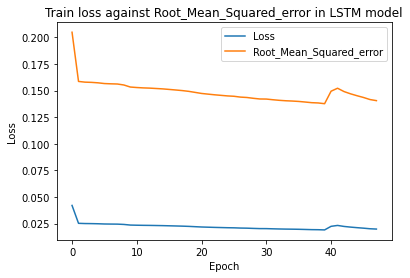

In [87]:
#Visualizing LSTM model Train Loss vs RMSE in LSTM model
plt.title('Train loss against Root_Mean_Squared_error in LSTM model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(LSTM_model_train.history['loss'])
plt.plot(LSTM_model_train.history['root_mean_squared_error'])
plt.legend(['Loss', 'Root_Mean_Squared_error'])

### Plotting graph for True vs Predicted BP values using LSTM Model
(with Normalized PPG and BP values)

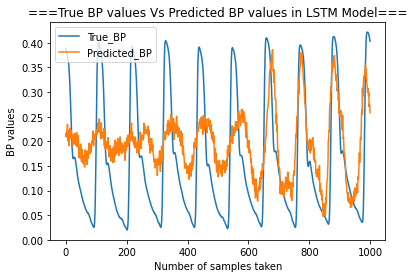

In [88]:
# Visualize predicted BP and the True BP for LSTM model
plt.title("===True BP values Vs Predicted BP values in LSTM Model===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[1000,:]) #only plotting 100 samples
plt.plot(LSTM_predictions[1000,:])
plt.legend(['True_BP', 'Predicted_BP'])